In [1]:
import numpy as np
import pandas as pd
from scipy.stats import kstest,ttest_ind
import itertools as it
from collections import Counter
import seaborn as sns
from matplotlib.ticker import MultipleLocator
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams.update({'font.size': 14, 'axes.linewidth': 2, 'xtick.major.width': 1.5, 'xtick.major.size': 7, 'ytick.major.width': 1.5, 'ytick.major.size': 7})
from matplotlib.backends.backend_pdf import PdfPages
from functools import reduce

In [2]:
def save_pdf(save_file, fig):
    pdf = PdfPages(save_file)
    pdf.savefig(fig, bbox_inches='tight')
    pdf.close()
    return

def get_combo_samples(combos, genotype_df):
    samples_per_combo = genotype_df.loc[genotype_df.gene.isin(combos)].samples.str.split(",").values
    samples = reduce(lambda a,b: set(a).intersection(set(b)), samples_per_combo)
    return samples



In [3]:
genotype_file = "/data6/deepro/ukb_bmi/0_data_preparation_and_download/genotype/data/processed_burden/all_gene_burden.csv.gz"
phenotype_file = "/data6/deepro/ukb_bmi/0_data_preparation_and_download/phenotype/data/bmi_processed/british/train_cohort_bmi.csv.gz"
combo_files = [
    "/data6/deepro/ukb_bmi/2_rarecomb/data/british/bonf_001/combo2.csv",
    "/data6/deepro/ukb_bmi/2_rarecomb/data/british/bonf_001/combo3.csv",
    "/data6/deepro/ukb_bmi/2_rarecomb/data/british/bonf_001/combo4.csv",
]

In [4]:
genotype_df = pd.read_csv(genotype_file)

phenotype_df = pd.read_csv(phenotype_file, usecols=["sample_names", "bmi", "bmi_prs"])
phenotype_df["bmi_decile"] = pd.qcut(phenotype_df.bmi, q=10)

combo_dfs = [pd.read_csv(cf, usecols=["uniq_items", "Case_Adj_Pval_bonf"]) for cf in combo_files]
combo_df = pd.concat(combo_dfs).reset_index(drop=True)
combo_df["combos"] = combo_df.uniq_items.apply(lambda x: [g.replace("Input_", "", 1) for g in x.split("|")])
combo_df["combo_samples"] = combo_df.combos.apply(get_combo_samples, args=(genotype_df, ))
all_combo_samples = reduce(lambda a,b: a.union(b), combo_df.combo_samples.values)

In [5]:
len(all_combo_samples)

1373

In [6]:
phenotype_combo_samples_df = phenotype_df.loc[phenotype_df.sample_names.astype(str).isin(list(map(str, all_combo_samples)))]
phenotype_other_samples_df = phenotype_df.loc[~phenotype_df.sample_names.astype(str).isin(list(map(str, all_combo_samples)))]

In [7]:
phenotype_combo_samples_decile_df = phenotype_combo_samples_df.groupby("bmi_decile", observed=True).agg({
    "sample_names": "count",
    "bmi_prs": "median",
    "bmi": "mean"}
    ).reset_index()
phenotype_combo_samples_decile_df["decile_rank"] = range(10)

In [8]:
bmi_prs_pop = phenotype_other_samples_df.groupby("bmi_decile", observed=True).agg({
    "sample_names": "count",
    "bmi_prs": "median",
    "bmi": "mean"}
    ).reset_index().bmi_prs

In [9]:
phenotype_other_samples_df["description"] = "Non Combo"

/tmp/ipykernel_97601/2061527731.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phenotype_other_samples_df["description"] = "Non Combo"


In [10]:
phenotype_combo_samples_df["description"] = "Combo"

/tmp/ipykernel_97601/3834674376.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phenotype_combo_samples_df["description"] = "Combo"


In [11]:
phenotype_samples_df = pd.concat((phenotype_combo_samples_df, phenotype_other_samples_df))

(-3.5, 3.5)

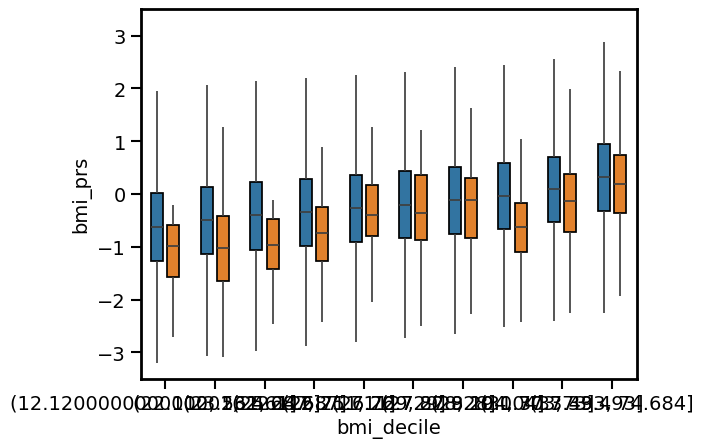

In [12]:
sns_ax = sns.boxplot(
    phenotype_samples_df, x="bmi_decile", y="bmi_prs", hue="description", hue_order=["Non Combo", "Combo"],
    width=0.65, linewidth=1.25, fliersize=0, capprops={'color':'none'}, boxprops={'edgecolor':'k'},
    legend=False, gap=0.25)

sns_ax.set_ylim(-3.5, 3.5)

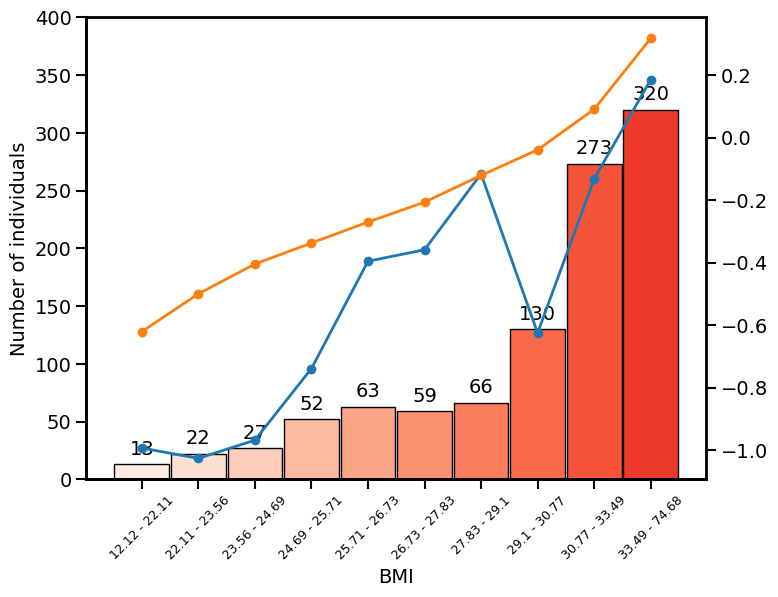

In [13]:
def create_decile_rank_plot(df, decile_labels, bmi_prs_samples, bmi_prs_population):
    fig,ax = plt.subplots(1,1,figsize=(8, 6))
    ax.bar(df.decile_rank, df.sample_names, width=0.97, color=sns.color_palette("Reds", 15).as_hex()[:10], edgecolor="k")
    xticklabels = decile_labels
    ax.set_xticks(range(10), xticklabels, rotation=45, ha="center", fontsize=9)
    ax.set_xlabel("BMI")
    ax.set_ylabel("Number of individuals")
    # g.bar_label([g.containers[i] for i in range])
    rects = ax.patches
    # Make some labels.
    for rect in rects:
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 5, f"{height}", ha="center", va="bottom"
        )
    ax.set_ylim(0, 400)
    ax.spines[['right', 'top']].set_visible(False)

    ax2 = ax.twinx()
    ax2.plot(range(10), bmi_prs_samples, marker="o", linewidth=2)
    ax2.plot(range(10), bmi_prs_population, marker="o", linewidth=2)
    return fig,ax

fig, ax = create_decile_rank_plot(
    phenotype_combo_samples_decile_df, 
    [" - ".join([str(round(v.left, 2)),str(round(v.right, 2))]) for v in  phenotype_combo_samples_decile_df.bmi_decile.values],
    phenotype_combo_samples_decile_df.bmi_prs.values,
    bmi_prs_pop
    )